In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)

In [3]:
from src.utils.tracklets import import_tracklets

roots = ["embryo007", "embryo008", "embryo014a", "embryo016", "embryo018"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadata, tracklets_joined = import_tracklets(datapath, roots)
print(spots[roots[0]].columns)

Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle'],
      dtype='object')


In [14]:
print(spots[roots[0]].head())

   Unnamed: 0    ID  track_id  tracklet_id  distance_from_edge  parent_id  \
0           0  2817         0            2           96.028167          0   
1           1  2692         1            9          101.966403          0   
2           2  2950         2           14           99.323588          0   
3           3  3846         3           15           70.186652          0   
4           4  2824         4           23           75.134796          0   

   daughter_id                                                roi  FRAME  \
0         2422  [4.60629251700675, 7.200680272108798, 6.606292...    0.0   
1         2336  [1.5259454705364988, 6.949868073878633, 4.5259...    0.0   
2         2597  [5.333333333333371, 6.5637254901960205, 7.3333...    0.0   
3         3104  [-0.16845878136200554, 7.976702508960557, 8.83...    0.0   
4         2429  [1.8898225957050272, 6.575163398692894, 4.8898...    0.0   

   POSITION_X  ...  SHAPE_INDEX  MEDIAN_INTENSITY_CH1  time  um_from_edge  \
0  

In [9]:
root = "embryo018"
spots_df = spots[root].copy()
spots_df = spots_df[spots_df["track_n_tracklets"] > 7]


from collections import defaultdict
from skimage.draw import polygon
import ast
df_dict = defaultdict(list)

def make_lineage_tif(spots_df: pd.DataFrame, h=1360, w=1360, key="ID") -> np.ndarray:
    shape = (round(spots_df["FRAME"].max()) + 1, h, w)
    output_tif = -np.ones(shape, dtype=np.float16)

    for i, spot in tqdm(spots_df.iterrows()):
        x, y = spot["POSITION_X"], spot["POSITION_Y"]
        t = round(spot["FRAME"])
        new_track_id = spot[key]
        
        roi = ast.literal_eval(spot["roi"])

        xs = [round(float(pt) + x) for pt in roi[::2]]
        ys = [round(float(pt) + y) for pt in roi[1::2]]

        rr, cc = polygon(ys, xs, shape[1:])
        output_tif[t, rr, cc] = new_track_id

    return output_tif

spots_df["AP_distance"] = spots_df["ap_position"] - spots_df["track_id"].map(spots_df.groupby("track_id")["ap_position"].first())
print(spots_df["AP_distance"].describe())
out = make_lineage_tif(spots_df, key="AP_distance")
tifffile.imwrite(datapath / root / f"{root}_ap_distance.tif", out)

count    199089.000000
mean          0.009089
std           0.020161
min          -0.063772
25%          -0.004530
50%           0.008272
75%           0.022001
max           0.099637
Name: AP_distance, dtype: float64


199089it [01:18, 2536.71it/s]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_10440\2671681709.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("inferno")


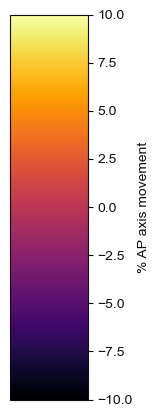

In [14]:
# make inferno colormap legend
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(1, 5))
cmap = cm.get_cmap("inferno")
norm = mcolors.Normalize(vmin=-10, vmax=10)
cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax)
cb.set_label("% AP axis movement")
plt.savefig(plotpath / "ap_distance_legend.png", dpi=300, bbox_inches="tight")

In [26]:
root = "embryo007"
rawfile = datapath / root / f"{root}_MaxIP_bgs.tif"
raw = tifffile.imread(rawfile)

spots_df = spots[root].copy()
spots_df.set_index("ID", inplace=True)

spots_df = spots_df[spots_df["track_n_tracklets"] == 31]

last_frame_nucs = spots_df[spots_df["FRAME"] == spots_df["FRAME"].max()]
sample = last_frame_nucs.sample(3)

crop_size = 25

for idx, nuc in sample.iterrows():
    series_dir = datapath / root / f"series_{idx}"
    series_dir.mkdir(exist_ok=True)
    while True:
        x, y = round(nuc["POSITION_X"]), round(nuc["POSITION_Y"])
        crop = raw[round(nuc["FRAME"]), y-crop_size:y+crop_size, x-crop_size:x+crop_size]
        tifffile.imwrite(series_dir / f"crop_{idx}_{str(round(nuc['FRAME'])).zfill(3)}.tif", crop)
        
        if nuc['parent_id'] == 0:
            break
        
        nuc = spots_df.loc[nuc['parent_id']]
        